<a href="https://colab.research.google.com/github/nikhilchalis/GANs/blob/main/GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
pip install torch torchvision matplotlib

In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [63]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [69]:
NOISE_SIZE = 5
NUM_INPUT_CLASSES = 10
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.embedding = nn.Embedding(NUM_INPUT_CLASSES, NOISE_SIZE)  # 10 classes, 10-dim embedding for each class
        self.model = nn.Sequential(
            nn.Linear(NOISE_SIZE*NUM_INPUT_CLASSES + NOISE_SIZE, 256),  # 100 for noise + 10 for class embedding
            nn.LeakyReLU(0.2),
            nn.Linear(256, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 28*28),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_embeddings = self.embedding(labels)  # Convert labels to embeddings
        x = torch.cat((noise, label_embeddings), dim=1)  # Concatenate noise and label embeddings
        return self.model(x).view(-1, 1, 28, 28)


In [70]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 28*28)
        return self.model(x)


In [71]:
generator = Generator()
discriminator = Discriminator()

criterion = nn.BCELoss()
lr = 0.001
optimizer_g = optim.Adam(generator.parameters(), lr=lr)
optimizer_d = optim.Adam(discriminator.parameters(), lr=lr)


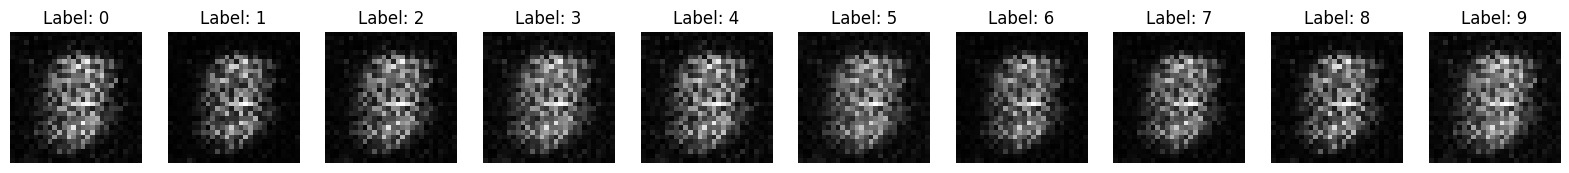

Epoch [1/20], d_loss: 0.4319, g_loss: 5.1984


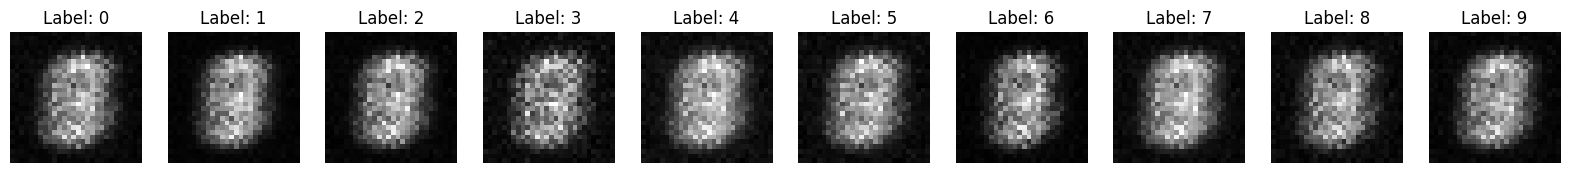

Epoch [2/20], d_loss: 1.3933, g_loss: 1.3300


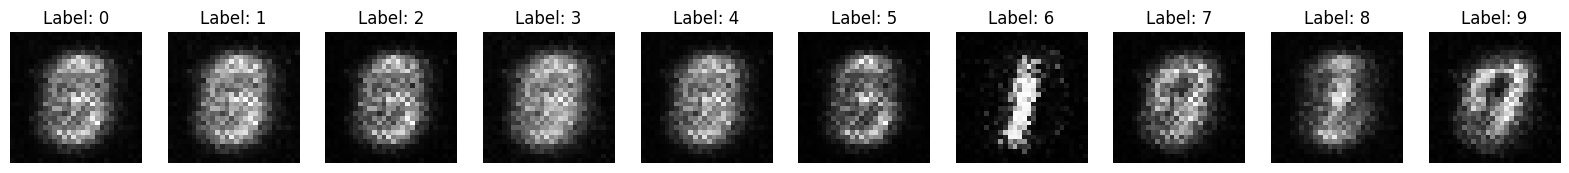

Epoch [3/20], d_loss: 0.4999, g_loss: 1.6358


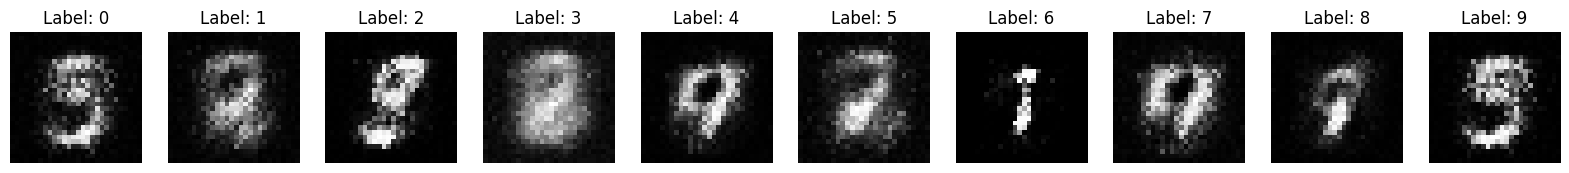

Epoch [4/20], d_loss: 0.7656, g_loss: 2.0548


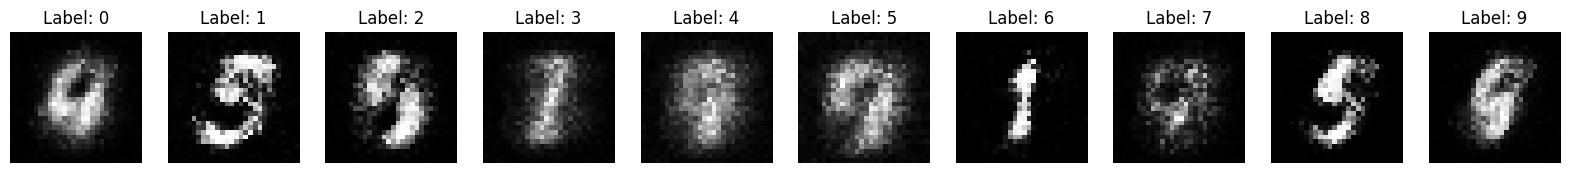

Epoch [5/20], d_loss: 1.1123, g_loss: 1.8706


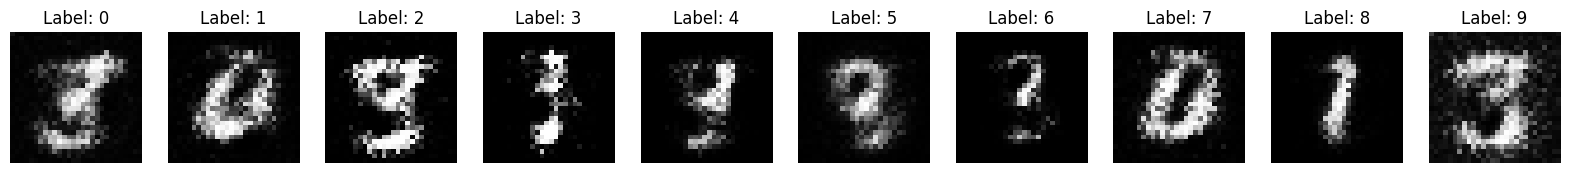

Epoch [6/20], d_loss: 1.0716, g_loss: 1.9107


In [ ]:
train = True

if train:
    plt.close()
    num_epochs = 20
    for epoch in range(num_epochs):
        for batch_idx, (real_images, real_labels) in enumerate(train_loader):
            batch_size = real_images.size(0)

            # Train Discriminator
            real_labels_one_hot = torch.ones(batch_size, 1)
            fake_labels_one_hot = torch.zeros(batch_size, 1)

            real_images = real_images.to(torch.float32)
            outputs = discriminator(real_images)
            d_loss_real = criterion(outputs, real_labels_one_hot)

            # Sample noise and random class labels
            z = torch.randn(batch_size, NUM_INPUT_CLASSES*NOISE_SIZE)
            random_labels = torch.randint(0, NUM_INPUT_CLASSES, (batch_size,))  # Random labels between 0-9

            # Generate fake images conditioned on the random labels
            fake_images = generator(z, random_labels)
            outputs = discriminator(fake_images.detach())
            d_loss_fake = criterion(outputs, fake_labels_one_hot)

            d_loss = d_loss_real + d_loss_fake
            optimizer_d.zero_grad()
            d_loss.backward()
            optimizer_d.step()

            # Train Generator
            outputs = discriminator(fake_images)
            g_loss = criterion(outputs, real_labels_one_hot)  # We want the fake images to be classified as real

            optimizer_g.zero_grad()
            g_loss.backward()
            optimizer_g.step()

        # DIsplay at the end of every epoch
        z = torch.randn(10, NUM_INPUT_CLASSES*NOISE_SIZE)  # 16 random noise vectors
        class_labels = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])  # Specific class labels
        fake_images = generator(z, class_labels)

        fake_images = fake_images.detach().numpy()
        fig, axes = plt.subplots(1, 10, figsize=(20, 5))

        for i in range(10):
            ax = axes[i]
            ax.imshow(fake_images[i].reshape(28, 28), cmap='gray')
            ax.set_title(f'Label: {class_labels[i].item()}')
            ax.axis('off')
        plt.show()

        print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}')

In [ ]:
z = torch.randn(16, NUM_INPUT_CLASSES*NOISE_SIZE)  # 16 random noise vectors
class_labels = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5])  # Specific class labels
fake_images = generator(z, class_labels)

fake_images = fake_images.detach().numpy()
fig, axes = plt.subplots(2, 8, figsize=(20, 5))
for i in range(16):
    ax = axes[i//8, i%8]
    ax.imshow(fake_images[i].reshape(28, 28), cmap='gray')
    ax.set_title(f'Label: {class_labels[i].item()}')
    ax.axis('off')
plt.show()